In [1]:
import requests
import pandas as pd
import dotenv
import os
import urllib.parse as urlparse
import datetime
from time import sleep
import numpy as np
import folium
import shapely
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle

### Getting AADT data from DPWH

In [2]:
# alternative api_call for returning geometries
# api_call = 'https://apps2.dpwh.gov.ph/server/rest/services/RTIA/AADT/MapServer/6/query?f=json&where=1%3D1&returnGeometry=true&spatialRel=esriSpatialRelIntersects&outFields=OBJECTID%2CREGION%2CDEO%2CROAD_NAME%2CSECTION_ID%2CSTART_DIST%2CEND_DIST%2CAADT%2CYEAR%2Ccreated_user%2Ccreated_date%2Clast_edited_user%2Clast_edited_date%2CShape.STLength()&outSR=102100&resultOffset=0&resultRecordCount=1000'

In [3]:
api_call = 'https://apps2.dpwh.gov.ph/server/rest/services/RTIA/AADT/MapServer/5/query?f=json&where=1%3D1&returnGeometry=false&spatialRel=esriSpatialRelIntersects&outFields=*&resultOffset=0&resultRecordCount=1000'

In [4]:
headers = {
    'authority': 'apps2.dpwh.gov.ph',
    'accept': '*/*',
    'accept-language': 'en-US,en;q=0.9',
    'dnt': '1',
    'if-none-match': '6e9848b9',
    'origin': 'https://dpwh.maps.arcgis.com',
    'referer': 'https://dpwh.maps.arcgis.com/apps/webappviewer/index.html?id=e2cf12e43f1247b2a436c87033f8fbc9',
    'sec-ch-ua': '"Not_A Brand";v="99", "Google Chrome";v="109", "Chromium";v="109"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'cross-site',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
}

In [27]:
AADT_query2year = {0:2021, 1:2020, 2:2019, 3:2018, 4:2017, 5:2016, 6:2015, 7:2013}
AADT_queries = range(0,8)

In [ ]:

final_jsons = []
for series in AADT_queries:
    result_offset = 0
    series_jsons = []
    while True:
        api_call = 'https://apps2.dpwh.gov.ph/server/rest/services/RTIA/AADT/MapServer/'+ str(series) +'/query?f=json&where=1%3D1&returnGeometry=false&spatialRel=esriSpatialRelIntersects&outFields=*&resultOffset='+ str(result_offset) +'&resultRecordCount=1000'
        try:
            api_request = requests.get(api_call, headers=headers, verify='dpwhtraffic.pem')
        except requests.exceptions.HTTPError as err:
            if err.errno == 429:
                raise('Too many requests')
            else:
                raise('Error unknown')
        sleep(1)
        api_response = api_request.json()
        if len(api_response['features']) > 0:
            series_jsons.append(api_response['features'])
        else: break
        result_offset += 1000
    with open('AADT_'+str(AADT_query2year.get(series))+'.p', 'wb') as file:
        pickle.dump(series_jsons, file)
        file.close()

### Combining AADT data into one

In [174]:
final_json = []
for series in AADT_queries:
    aadt_json = pickle.load(open('AADT_{0}.p'.format(AADT_query2year.get(series)) ,'rb'))
    flattened = [entry for json_chunk in aadt_json for entry in json_chunk]
    final_json.append(flattened)
    flattened = []
final_json = [entry['attributes'] for each_json in final_json for entry in each_json]

In [175]:
aadt_df = pd.DataFrame.from_dict(final_json)
aadt_df

,OBJECTID,REGION,DEO,ROAD_NAME,SECTION_ID,START_DIST,END_DIST,AADT,YEAR,created_user,created_date,last_edited_user,last_edited_date,Shape.STLength(),ROAD_SECTI,NEW_AADT,NEW_VCR,DISTRICT,AADT_YEAR,VCR
0,1,Region II,Batanes District Engineering Office,Sn Vicente-Savidug-Chavayan-Sumnanga-Nakanmuan Rd,S00003ST,355.0,430.0,518.0,2021.0,GISADMIN,1.666172e+12,GISADMIN,1.666172e+12,75.366948,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Region IV-B,Palawan 1st District Engineering Office,Coron-Busuanga Rd,S00001CR,31670.0,32700.0,1735.0,2021.0,GISADMIN,1.666172e+12,GISADMIN,1.666172e+12,1015.110819,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Region IV-B,Mindoro Oriental District Engineering Office,Calapan South Rd,S00007MR,38273.0,38714.0,7706.0,2021.0,GISADMIN,1.666172e+12,GISADMIN,1.666172e+12,440.964182,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Region VIII,Northern Samar 1st District Engineering Office,Daang Maharlika (SM) (Sn Isidro-Sn Juanico Br),S00002SM,9853.0,9908.0,3537.0,2021.0,GISADMIN,1.666172e+12,GISADMIN,1.666172e+12,55.023188,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Region VIII,Tacloban City District Engineering Office,Leyte-Samar Rd (via Guintigui-an),S00001LT,337.0,494.0,10857.0,2021.0,GISADMIN,1.666172e+12,GISADMIN,1.666172e+12,155.963251,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296934,6329,Region V,NaN,Sta. Elena-Capalonga By Pass Coastal Rd,NaN,NaN,NaN,2544.0,NaN,NaN,NaN,NaN,NaN,80.975214,S06075LZ,2544.0,0.047157,Camarines Norte District Engineering Office,2013.0,0.047
296935,6330,Region V,NaN,Sta. Elena-Capalonga By Pass Coastal Rd,NaN,NaN,NaN,2544.0,NaN,NaN,NaN,NaN,NaN,218.632510,S06075LZ,2544.0,0.056589,Camarines Norte District Engineering Office,2013.0,0.057
296936,6331,Region V,NaN,Sta. Elena-Capalonga By Pass Coastal Rd,NaN,NaN,NaN,2544.0,NaN,NaN,NaN,NaN,NaN,5764.466050,S06075LZ,2544.0,0.059567,Camarines Norte District Engineering Office,2013.0,0.060
296937,6332,Region V,NaN,Sta. Elena-Capalonga By Pass Coastal Rd,NaN,NaN,NaN,2544.0,NaN,NaN,NaN,NaN,NaN,5619.580427,S06075LZ,2544.0,0.094315,Camarines Norte District Engineering Office,2013.0,0.094


In [176]:
aadt_df['YEAR'] = aadt_df['YEAR'].combine_first(aadt_df['AADT_YEAR'])
aadt_df['DEO'] = aadt_df['DEO'].combine_first(aadt_df['DISTRICT'])

### AADT Trend in Select Roads in Cavite

In [178]:
aguinaldo_hway = aadt_df[(aadt_df['REGION'] == 'Region IV-A') & (aadt_df['ROAD_NAME'] == 'Cavite-Batangas Rd')][['YEAR','AADT']]
governors = aadt_df[(aadt_df['REGION'] == 'Region IV-A') & (aadt_df['ROAD_NAME'] == 'Juanito R. Remulla, Sr. Rd')][['YEAR','AADT']]
manila_cavite = aadt_df[(aadt_df['REGION'] == 'Region IV-A') & (aadt_df['ROAD_NAME'] == 'Manila-Cavite (NCR Bdry-Jct Cavite City Sect)')][['YEAR','AADT']]
gentri_tejero = aadt_df[(aadt_df['REGION'] == 'Region IV-A') & (aadt_df['ROAD_NAME'] == 'Tejero-Gen Trias-Amadeo-Tagaytay Rd')][['YEAR','AADT']]

In [179]:
grouper = aguinaldo_hway.groupby('YEAR')['AADT']
year_average_aguinaldo = grouper.transform('mean')

grouper = governors.groupby('YEAR')['AADT']
year_average_governors = grouper.transform('mean')

grouper = manila_cavite.groupby('YEAR')['AADT']
year_average_manilacav = grouper.transform('mean')

grouper = gentri_tejero.groupby('YEAR')['AADT']
year_average_gentej = grouper.transform('mean')

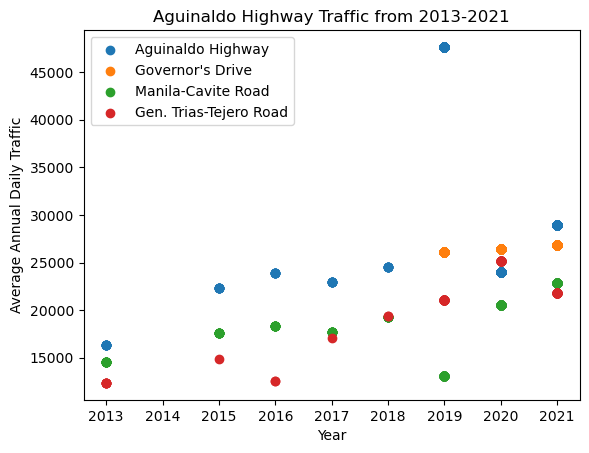

In [181]:
fig1, ax1 = plt.subplots(1)
ax1.scatter(x=aguinaldo_hway['YEAR'], y=year_average_aguinaldo)
ax1.scatter(x=governors['YEAR'], y=year_average_governors)
ax1.scatter(x=manila_cavite['YEAR'], y=year_average_manilacav)
ax1.scatter(x=gentri_tejero['YEAR'], y=year_average_gentej)
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Annual Daily Traffic')
ax1.set_title('Aguinaldo Highway Traffic from 2013-2021')
ax1.legend(['Aguinaldo Highway', "Governor's Drive", 'Manila-Cavite Road', 'Gen. Trias-Tejero Road']);